<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SqRA" data-toc-modified-id="SqRA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>SqRA</a></span><ul class="toc-item"><li><span><a href="#Using-full-FG" data-toc-modified-id="Using-full-FG-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Using full FG</a></span></li><li><span><a href="#Using-only-positions" data-toc-modified-id="Using-only-positions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Using only positions</a></span></li><li><span><a href="#Using-only-orientations" data-toc-modified-id="Using-only-orientations-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Using only orientations</a></span></li></ul></li><li><span><a href="#MSM" data-toc-modified-id="MSM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MSM</a></span></li><li><span><a href="#HF--HF" data-toc-modified-id="HF--HF-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>HF -HF</a></span><ul class="toc-item"><li><span><a href="#Pseudotrajectory" data-toc-modified-id="Pseudotrajectory-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Pseudotrajectory</a></span></li></ul></li></ul></div>

The story:

    1) Wanted to create some HF-HF examples with a full grid of orientations/positions 
    2) Adapting a FF created some weird results, so I returned to water as example
    3) First task was assigning structures to position classes (already done), orientation classes and combining
    4) First results appeared weird (seemingly random structures in the same orientation class)
    5) Built a ViewManager tool using NGLView to understand them better
    6) Discovered my conceptual error and changed the approach (double-rotation to position molecules)
    7) Now assignments seem to work (tested with PTs + visual)
    8) Created H2O-H2O example
    9) Went back to creating HF force field, seems to be at least somewhat working
    10) Created HF-HF example
    
Issues:

    1) HF force-field: if length of bonds not restricted, completely wrong behaviour
    2) ITSs that don't look right
    3) determining diffusion constant in SQRA?
    

In [1]:
import sys
import os

try:
    os.chdir(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup/molgri")
    sys.path.append(r"/home/hanaz63/PAPER_MOLECULAR_ROTATIONS_2022/nobackup")
except FileNotFoundError:
    os.chdir(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    sys.path.append(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    
import warnings
warnings.filterwarnings("ignore")

In [6]:
import numpy as np
from scipy.spatial.transform import Rotation
import MDAnalysis as mda
from IPython.core.display import display
import matplotlib.pyplot as plt

from molgri.molecules.parsers import FileParser
from molgri.molecules.writers import PtIOManager
from molgri.molecules.transitions import SimulationHistogram, SQRA, MSM
from molgri.space.fullgrid import FullGrid
from molgri.paths import PATH_INPUT_BASEGRO
from molgri.plotting.widgets import ViewManager, display_all_views, sync_all_views
from molgri.space.rotations import two_vectors2rot
from molgri.space.utils import k_argmax_in_array, k_argmin_in_array
from molgri.plotting.transition_plots import TransitionPlot

## SqRA

In [7]:
fg_full = FullGrid("20", "42", "linspace(0.25, 0.35, 5)", use_saved=False)
fg_position = FullGrid("1", "42", "linspace(0.25, 0.35, 5)", use_saved=False)
fg_orientation = FullGrid("20", "1", "1", use_saved=False)

pt_used = "H2O_H2O_0402"


Warning! For <=4 points, volumes, areas etc are only estimated.
Warning! For <=4 points, volumes, areas etc are only estimated.


### Using full FG

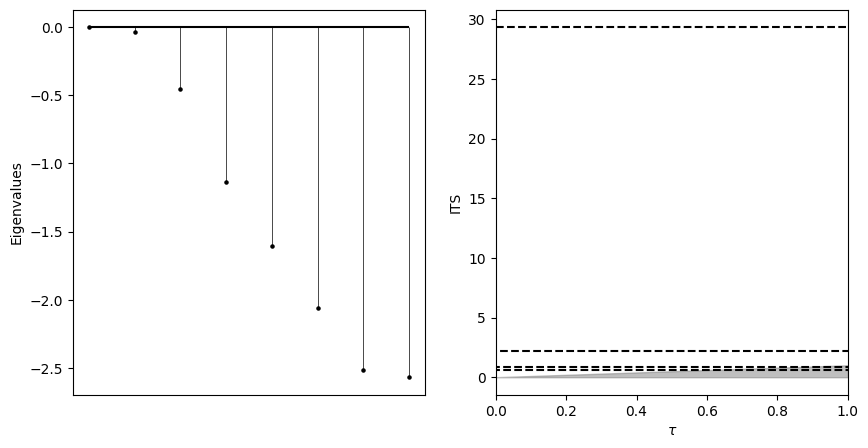

In [9]:
sh = SimulationHistogram(pt_used, is_pt=True, second_molecule_selection="bynum 4:6",
                            full_grid=fg_full, use_saved=True)
sqra = SQRA(sh)
sqra.assignments =  np.arange(0, len(sh.full_grid))
tp = TransitionPlot(sh)
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))
tp.plot_eigenvalues(num_eigenv=5, save=False, fig=fig, ax=ax[0])
tp.plot_its(5, as_line=True, save=False, fig=fig, ax=ax[1])
plt.show()

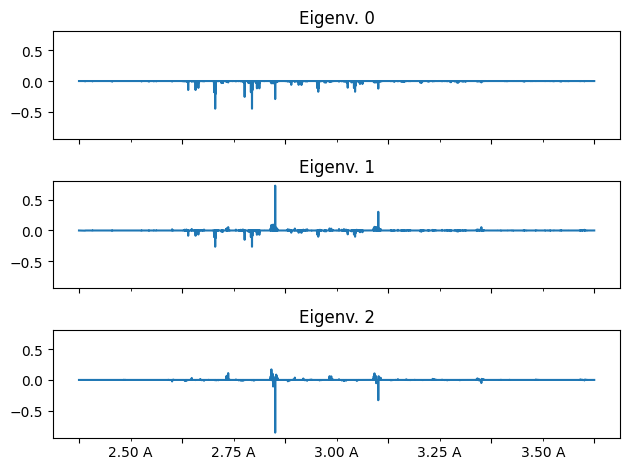

In [10]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
# set-up x-ticks
all_radii = sh.full_grid.get_radii()
ticks_where = np.arange(0, len(sh.full_grid)+1, sh.full_grid.get_b_N()*sh.full_grid.get_o_N())
ticks_between = [(ticks_where[i]+ticks_where[i+1])/2 for i in range(0, len(all_radii)-1)]
ticks_between.append(ticks_between[-1] + (ticks_between[-1] - ticks_between[-2]))
tick_labels = [f"{all_radii[i]:.2f} A" for i in range(0, len(all_radii))]

# plot
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i])
    ax[i].set_xticks(ticks_where, labels="")

ax[2].set_xticks(ticks_between,  minor=True)
ax[2].set_xticklabels(tick_labels, minor=True)
plt.tight_layout()
plt.show()

In [12]:
# take structures from most populated cells of eigenvector 0 

vm = ViewManager(sh.trajectory_universe)
vm.fresh_view()

# largest absolute values of 0th eigevector
num_extremes = 5
magnitudes = sh.get_magnitude_ith_eigenvector(0)
argmax_index = k_argmax_in_array(np.abs(magnitudes), num_extremes)
print(f"{num_extremes} Most popular cells of FullGrid: {argmax_index}")



vm.plot_frames_overlapping(argmax_index)
vm.view

5 Most popular cells of FullGrid: [1113 1110 1410 1599 1350]


NGLWidget()

In [16]:
# take structures from most + and most - eigenvector 1

vm.fresh_view()

magnitudes = sh.get_magnitude_ith_eigenvector(1)
vm.set_color_magnitude(magnitudes, )
print(magnitudes.shape)

# 
num_extremes = 2
most_positive = np.argmax(magnitudes)
most_negative = np.argmin(magnitudes)
print(f"2nd position eigenvector has most negative cell {most_negative} and most positive cell {most_positive}.")
# now assign these to trajectory frames
assigned_frames = []
colors = []
for one_argmax in [most_negative, most_positive]:
    all_assigned = one_argmax
    assigned_frames.append(all_assigned)
    colors.extend([vm.current_magnitudes[one_argmax]])
vm.current_magnitudes = None

vm.plot_frames_overlapping(assigned_frames, colors=colors)
vm.view

(4200,)
2nd position eigenvector has most negative cell 1110 and most positive cell 1599.


NGLWidget()

In [34]:
# take structures from most + and most - eigenvector 2

vm.fresh_view()

magnitudes = sh.get_magnitude_ith_eigenvector(2)
vm.set_color_magnitude(magnitudes, )
print(magnitudes.shape)

# 
num_extremes = 2
most_positive = np.argmax(magnitudes)
most_negative = np.argmin(magnitudes)
print(f"2nd position eigenvector has most negative cell {most_negative} and most positive cell {most_positive}.")
# now assign these to trajectory frames
assigned_frames = []
colors = []
for one_argmax in [most_negative, most_positive]:
    all_assigned = one_argmax
    assigned_frames.append(all_assigned)
    colors.extend([vm.current_magnitudes[one_argmax]])
vm.current_magnitudes = None

vm.plot_frames_overlapping(assigned_frames, colors=colors)
vm.view

(210,)
2nd position eigenvector has most negative cell 41 and most positive cell 10.


NGLWidget()

### Using only positions

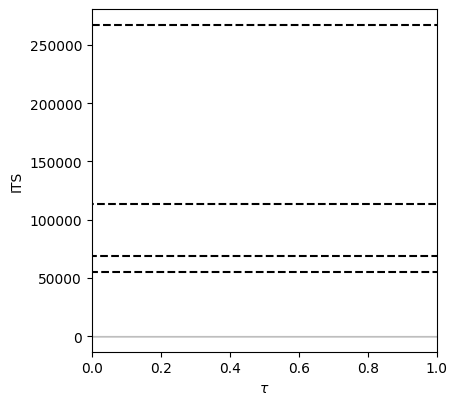

In [39]:
sh = SimulationHistogram(pt_used, is_pt=True, second_molecule_selection="bynum 4:6",
                            full_grid=fg_position, use_saved=True)
n_b = sh.full_grid.get_b_N()
n_position_grid = len(sh.full_grid.get_position_grid_as_array())
repeated_natural_num = np.repeat(np.arange(n_position_grid), n_b)
sh.full_assignments = repeated_natural_num
tp = TransitionPlot(sh)
tp.transition_obj.assignments = repeated_natural_num
tp.plot_its(5, as_line=True, save=False)
plt.show()

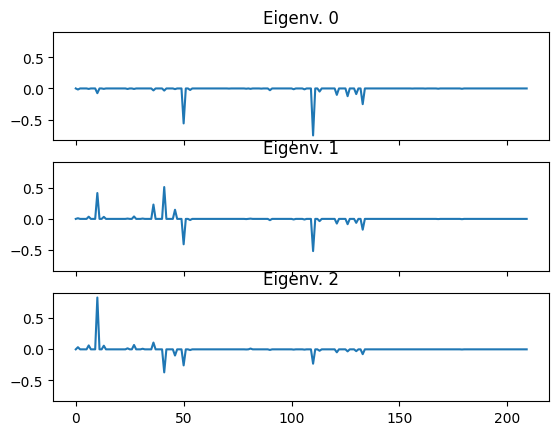

In [40]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i])
plt.show()

In [44]:
# investigate max and min populated eigenv 0

vm = ViewManager(sh.trajectory_universe)
vm.fresh_view()

magnitudes = sh.get_magnitude_ith_eigenvector(0)
vm.set_color_magnitude(magnitudes, )
print(magnitudes.shape)

# 
num_extremes = 2
most_positive = np.argmax(magnitudes)
most_negative = np.argmin(magnitudes)
print(f"2nd position eigenvector has most negative cell {most_negative} and most positive cell {most_positive}.")
# now assign these to trajectory frames
assigned_frames = []
colors = []
for one_argmax in [most_negative, most_positive]:
    all_assigned = one_argmax
    assigned_frames.append(all_assigned)
    colors.extend([vm.current_magnitudes[one_argmax]])
vm.current_magnitudes = None

vm.plot_frames_overlapping(assigned_frames, colors=colors)
vm.view

(210,)
2nd position eigenvector has most negative cell 110 and most positive cell 161.


NGLWidget()

### Using only orientations

In 4D, only approximate calculation of Voronoi cells is possible. Proceeding numerically.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


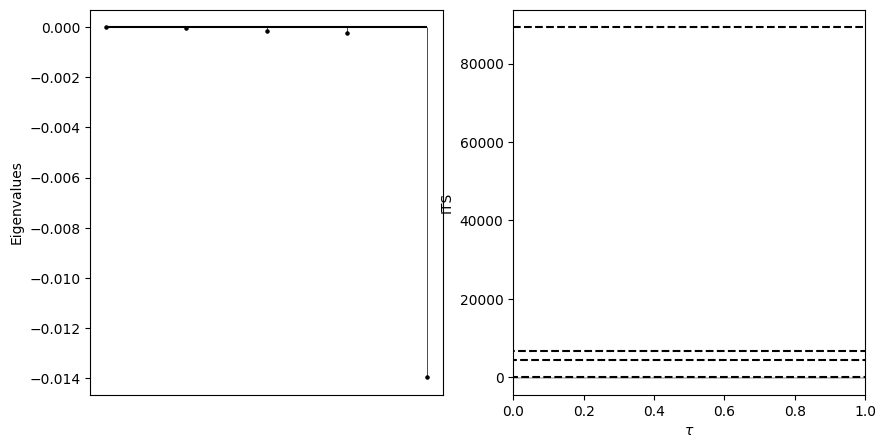

In [49]:
sh = SimulationHistogram(pt_used, is_pt=True, second_molecule_selection="bynum 4:6",
                            full_grid=fg_orientation, use_saved=False)
sh.full_assignments = sh.full_grid.get_quaternion_index()

tp = TransitionPlot(sh)
tp.transition_obj.assignments = sh.full_grid.get_quaternion_index()
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))
tp.plot_eigenvalues(num_eigenv=5, save=False, fig=fig, ax=ax[0])
tp.plot_its(5, as_line=True, save=False, fig=fig, ax=ax[1])
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


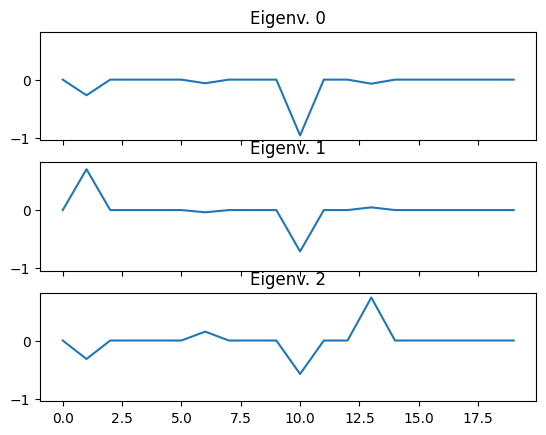

In [51]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i])
plt.show()

In [67]:
# investigate max and min populated eigenv 1
# take structures from most populated eigenvector 0 

vm = ViewManager(sh.trajectory_universe)
vm.fresh_view()
magnitudes = sh.get_magnitude_ith_eigenvector(1)
vm.set_color_magnitude(magnitudes, )

# 
num_extremes = 1
most_positive = k_argmax_in_array(np.abs(magnitudes), num_extremes)
most_negative = k_argmin_in_array(np.abs(magnitudes), num_extremes)
print(f"1st orientation eigenvector has most negative cell {most_negative} and most positive cell {most_positive}.")
# now assign these to trajectory frames
assigned_frames = []
colors = []
for multi_argmax in [most_negative, most_positive]:
    for one_argmax in multi_argmax:
        all_assigned = np.where(fg_full.get_quaternion_index()==one_argmax)[0][:10]
        assigned_frames.extend(all_assigned)
        colors.extend([vm.current_magnitudes[one_argmax]]*len(all_assigned))
vm.current_magnitudes = None

vm.plot_frames_overlapping(assigned_frames, colors=colors)
vm.view

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


1st orientation eigenvector has most negative cell [19] and most positive cell [10].


NGLWidget()

## MSM

In [117]:
traj_used = "H2O_H2O_0095_2000"
fg_msm = FullGrid("8", "12", "linspace(0.25, 0.35, 5)", use_saved=False)
sh_traj_full = SimulationHistogram(traj_used, is_pt=False, second_molecule_selection="bynum 4:6",
                            full_grid=fg_msm, use_saved=False)

In [118]:
sh_traj_full.get_full_assignments()

array([464, 432, 432, ..., 109, 109, 109], dtype=int64)

In [120]:
tau_array=np.array([10, 20, 30, 40, 50, 70, 100, 120, 150, 200, 500])
from molgri.molecules.transitions import MSM
msm = MSM(sh_traj_full, tau_array)
#msm.use_saved = False
msm.assignments = sh_traj_full.get_full_assignments()
#msm.transition_matrix = None
msm.get_transitions_matrix()
print(msm.transition_matrix.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.01it/s]

(11, 480, 480)


In [113]:
msm.get_eigenval_eigenvec(6);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.91it/s]


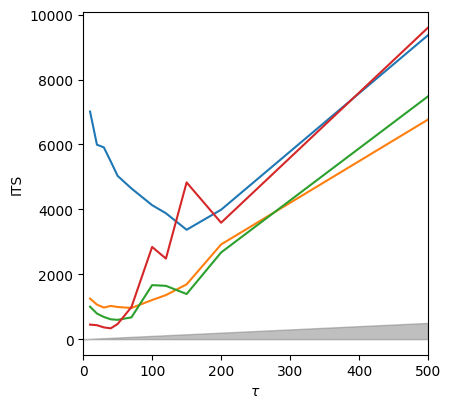

In [121]:
tp = TransitionPlot(sh_traj_full, tau_array)
tp.transition_obj.use_saved = False
tp.transition_obj = msm
tp.plot_its(5, as_line=False, save=False)
#tp.ax.set_ylim(0, 5000)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.95it/s]


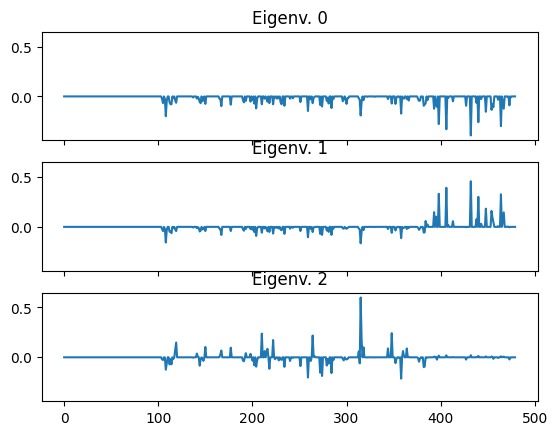

In [122]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i])
plt.show()

In [ ]:
# TODO: try to make quaternion assignments significantly faster
# TODO: network flow plot for strongest rates?

# TODO: make transition matrix determination faster and try it for a large matrix
# TODO: HF forcefield and calculations

## HF -HF

In [123]:
traj_used_ts = "ts_ts"
fg_msm = FullGrid("8", "12", "linspace(0.25, 0.35, 5)", use_saved=False)
sh_traj_full_ts = SimulationHistogram(traj_used_ts, is_pt=False, second_molecule_selection="bynum 4:6",
                            full_grid=fg_msm, use_saved=False)

In [124]:
# plot 10 lowest energies

# display
vm = ViewManager(sh_traj_full_ts.trajectory_universe)
vm.fresh_view()

# magnitudes
magnitudes = sh_traj_full_ts.get_magnitude_energy("Potential")

num_extremes = 10
argmin_index = k_argmin_in_array(magnitudes, num_extremes)
vm.plot_frames_overlapping(argmin_index, opacities=0.8)

NGLWidget()

In [125]:
sh_traj_full_ts.get_full_assignments()

array([394, 464, 441, ..., 418, 472, 416], dtype=int64)

In [25]:
tau_array=np.array([5, 7, 10, 20, 25, 30, 35, 40, 50, 70, 100, 120, 150, 200, 300, 500])
from molgri.molecules.transitions import MSM
msm = MSM(sh_traj_full_ts, tau_array)
msm.assignments = sh_traj_full.get_full_assignments()
msm.get_transitions_matrix();

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.64it/s]


In [126]:
msm.get_eigenval_eigenvec(6);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.97it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.91it/s]


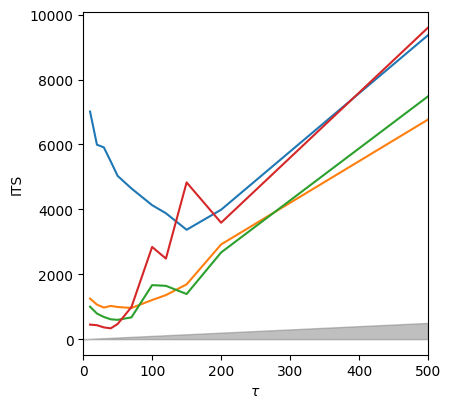

In [127]:
tp = TransitionPlot(sh_traj_full_ts, tau_array)
tp.transition_obj.use_saved = False
tp.transition_obj = msm
tp.plot_its(5, as_line=False, save=False)
#tp.ax.set_ylim(0, 5000)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.24it/s]


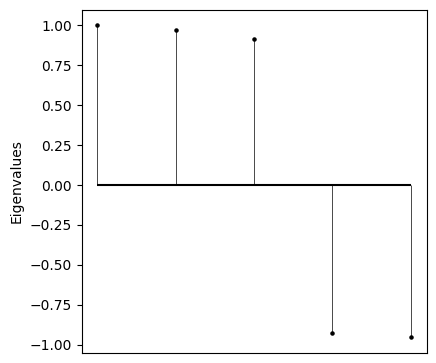

In [128]:
tp.plot_eigenvalues(num_eigenv=5, save=False, index_tau=7)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.80it/s]


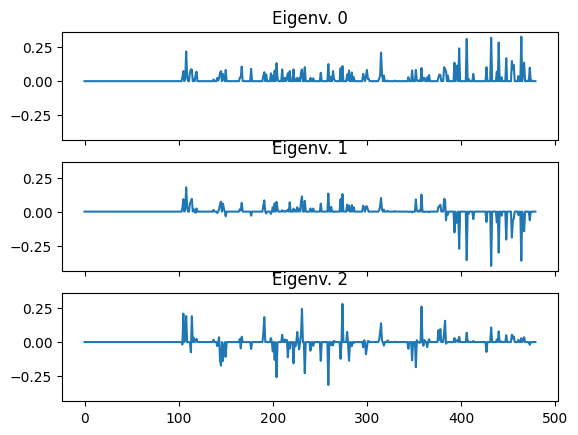

In [129]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i], index_tau=7)
plt.show()

### Pseudotrajectory

In [93]:
pt_used_ts = "ts_ts_0012"
fg_full_ts = FullGrid("20", "12", "linspace(0.25, 0.45, 5)", use_saved=False)
sh_pt_full_ts = SimulationHistogram(pt_used_ts, is_pt=True, second_molecule_selection="bynum 4:6",
                            full_grid=fg_full_ts, use_saved=False)

In [94]:
# plot 10 lowest energies

# display
vm = ViewManager(sh_pt_full_ts.trajectory_universe)
vm.fresh_view()

# magnitudes
magnitudes = sh_pt_full_ts.get_magnitude_energy("Potential")

num_extremes = 20
argmin_index = k_argmin_in_array(magnitudes, num_extremes)
print(list(argmin_index))
vm.plot_frames_overlapping(argmin_index, opacities=0.8)

[160 219  80  36 182 220 239 162 202  50 159   2 382  99 142 179  79 319
  60 140]


NGLWidget()

In [95]:
from molgri.molecules.transitions import SQRA
sqra = SQRA(sh_pt_full_ts)
sqra.assignments = np.arange(0, len(sh_pt_full_ts.full_grid))
rates_matrix = sqra.get_transitions_matrix()

In 4D, only approximate calculation of Voronoi cells is possible. Proceeding numerically.


In [96]:
# only orientation clases
vm = ViewManager(sh_pt_full_ts.trajectory_universe)
vm.fresh_view()

all_views = []
for i in [2, 3, 5]:
    indices = np.where(sh_pt_full_ts.full_grid.get_quaternion_index()==i)
    view = vm.plot_frames_overlapping(indices, opacities=0.8)
    all_views.append(view)

sync_all_views(all_views)
display_all_views(all_views)

Box(children=(NGLWidget(), NGLWidget(), NGLWidget()), layout=Layout(display='inline-flex', flex_flow='row wrap…

In [97]:
tp = TransitionPlot(sh_pt_full_ts)
tp.transition_obj.assignments = np.arange(0, len(sh_pt_full_ts.full_grid))
tp.plot_eigenvalues(5, save=False)
#tp.ax.set_ylim(0, 5000)
plt.show()

In 4D, only approximate calculation of Voronoi cells is possible. Proceeding numerically.


  0%|                                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]


ValueError: array must not contain infs or NaNs

In [ ]:
fig, ax = plt.subplots(3, sharex=True, sharey=True)
for i in range(3):
    tp.plot_one_eigenvector_flat(i, save=False, fig=fig, ax=ax[i])
plt.show()